There is a signal x(t) and we want to take the action +1 if we believe that the signal will continue to go up, and -1 if we believe that the signal will continue to go down. We will take no action if our current belief on the behavior of the signal does not change. The reward is the difference between the signal value at each action change. That is, if we take action +1 at t1, and -1 at t2>t1, then the reward is x(t2)-x(t1). If we take action -1 at t1 and +1 at t2>t1, then the reward is -(x(t2)-x(t1)).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import numpy as np
import random

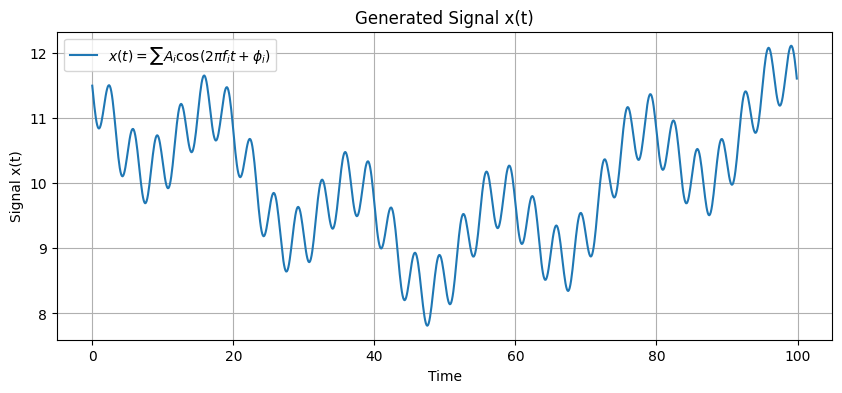

In [2]:
# Parameters
T = 100  # Total time steps
dt = 0.1  # Time step increment
t = np.arange(0, T, dt)  # Time array

# Frequencies and amplitudes of the cosines
freqs = [0.01, 0.05, 0.3]  # Hz
amps = [1.0, 0.7, 0.5]  # Amplitudes
phases = [0, np.pi/4, np.pi/2]  # Phase shifts

# freqs = [0.01]  # Hz
# amps = [1.0]  # Amplitudes
# phases = [0]  # Phase shifts

# Generate the signal as a sum of cosines
x_t = 10+sum(A * np.cos(2 * np.pi * f * t + phi) for A, f, phi in zip(amps, freqs, phases))

# Plot the signal
plt.figure(figsize=(10, 4))
plt.plot(t, x_t, label=r'$x(t) = \sum A_i \cos(2\pi f_i t + \phi_i)$')
plt.xlabel('Time')
plt.ylabel('Signal x(t)')
plt.title('Generated Signal x(t)')
plt.legend()
plt.grid()
plt.show()


In [3]:
def detect_changes(lst):
    change_indices = [0]  # The first index is always a change
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            change_indices.append(i)
    change_indices.append(len(lst) - 1)  # The last index is always a change

    return change_indices

In [4]:
class Environment:
   def __init__(self, t, x_t, ntau):
      self.x_t = x_t  # Signal values
      self.t = t
      self.ntau = ntau

   def evaluate(self):
      retval=0
      idx_changes=detect_changes(self.actions)
      self.rewards=[0]*len(self.x_t)
      for ni in range(1,len(idx_changes)):
          period=idx_changes[ni-1:ni+1]
          action=self.actions[period[0]]

          p0=self.x_t[period[0]]
          p1=self.x_t[period[1]]
          if action==1:
            value=p1-p0
          elif action==-1:
            value=p0-p1
          else:
            value=0
          self.rewards[period[1]]=value
          retval+=value
      return retval

   def calculateDiscountedRewards(self, gamma):
      discounted_rewards = []
      R = 0
      for r in reversed(self.rewards):
          R = r + gamma * R
          discounted_rewards.insert(0, R)
      return np.array(discounted_rewards)

   # Function to compute the state
   def compute_state(self, nt):
      if nt < self.ntau:
          return None  # Not enough history to compute state

      prev_x = self.x_t[nt-self.ntau]  # x(t-tau)
      state = np.log10(np.array([self.x_t[nt-self.ntau+1:nt]], dtype=np.float32)/prev_x)
      return state

   def executePolicy(self, policy):
      self.actions=[0]*len(self.x_t)
      for ni in range(len(self.x_t)):
          state = self.compute_state(ni)
          if state is not None:
            self.actions[ni] = policy.select_action(state)

   def drawResult(self):
      # Convert actions into colors
      color_map = {+1: 'blue', 0:'black', -1: 'red'}

      # Create a continuous plot with correct coloring
      plt.figure(figsize=(12, 5))

      idx_changes=detect_changes(self.actions)
      for ni in range(len(idx_changes)-1):
          period=idx_changes[ni:ni+2]
          action=self.actions[period[0]]
          plt.plot(self.t[period[0]:period[1]], self.x_t[period[0]:period[1]],
                  color=color_map[action], linewidth=2)

      plt.xlabel("Time")
      plt.ylabel("Signal x(t)")
      plt.title("Action-Based Colored Line Plot of x(t)")
      plt.show()


In [5]:
# Trivial solution
# Define the neural network
class PolicyNetworkTrivial():
    def forward(self, state):
        if state[0][-1] > 0:
            action = +1
        elif state[0][-1] < 0:
            action = -1
        else:
            action = 0
        return action

    def select_action(self, state):
        return self.forward(state)

Value= 47.8052403074072


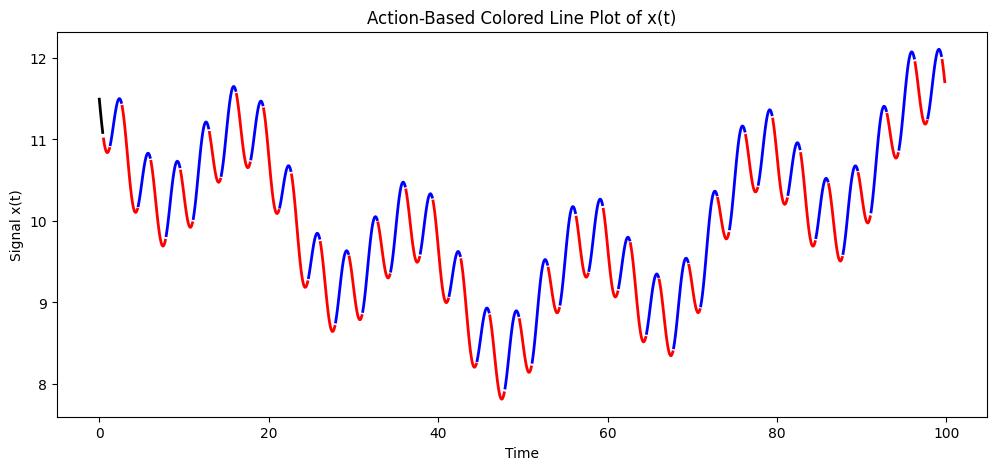

In [6]:
ntau = 5
policy = PolicyNetworkTrivial()
env = Environment(t, x_t, ntau)
env.executePolicy(policy)
print("Value=",env.evaluate())
env.drawResult()

In [7]:
# Define the neural network
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=8, output_size=2):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.fc3 = nn.Linear(hidden_size, output_size, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        # desired_weights = torch.tensor([[-100], [100]], dtype=torch.float32)  # Shape (3,1)

        # Assign the weights properly
        # with torch.no_grad():  # Disable gradient tracking
        #     self.fc1.weight.data = desired_weights  # Direct assignment
        self.epsilon = 0.05  # Exploration rate

    def forward(self, state):
        x = self.sigmoid(self.fc1(state))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

    def select_action(self, state):
        # Epsilon greedy
        if random.uniform(0, 1) < self.epsilon:  # Exploration
            action = random.choice([-1, +1])  # Random action
        else:  # Exploitation
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert state to tensor
            action_probs = self.forward(state)
            action_index = torch.argmax(action_probs).item()  # Choose action with highest value
            action = [-1, +1][action_index]  # Map index to action
            #action = random.choices([-1, +1], weights=action_probs.squeeze().detach().numpy(), k=1)[0]

        return action

In [8]:
# Define environment parameters
ntau = 5
num_episodes = 1000  # Increase episodes for proper training
gamma = 0.99  # Discount factor
learning_rate = 0.01

# Initialize Policy Network
policy_net = PolicyNetwork(ntau-1)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training loop
env = Environment(t, x_t, ntau)  # Initialize environment

for episode in range(num_episodes):
    state_history = []  # Store states
    action_history = []  # Store actions

    # Execute policy and collect trajectories
    for nt in range(len(env.x_t)):
        state = env.compute_state(nt)  # Compute current state
        if state is not None:
            state_history.append(state)
            action = policy_net.select_action(state)  # Choose action
            action_history.append(action)
        else:
            state_history.append(None)
            action_history.append(0)  # No action taken

    # Evaluate rewards based on selected actions
    env.executePolicy(policy_net)  # Set `env.actions`
    total_reward = env.evaluate()  # Compute reward
    discounted_rewards = env.calculateDiscountedRewards(gamma)

    # Convert actions to tensor indices
    action_indices = torch.tensor([[-1, +1].index(a) for a in action_history[ntau:]], dtype=torch.long)

    # Convert state history to tensor
    state_tensor = torch.tensor(state_history[ntau:], dtype=torch.float32)

    # Forward pass through policy network
    action_probs = policy_net(state_tensor)  # Get raw action scores

    # Compute log probabilities of selected actions
    log_probs = torch.log(action_probs.gather(2, action_indices.unsqueeze(1).unsqueeze(2)) + 1e-8).squeeze()

    # Normalize rewards for stability
    discounted_rewards = torch.tensor(discounted_rewards[ntau:], dtype=torch.float32)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) #/ (discounted_rewards.std() + 1e-8)

    # Compute loss
    loss = -torch.sum(log_probs * discounted_rewards)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()

    # Print progress
    if episode % 50 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Loss: {loss.item():.4f}")



<ipython-input-8-34aed641233b>:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state_tensor = torch.tensor(state_history[ntau:], dtype=torch.float32)


Episode 0, Total Reward: -0.05, Loss: -0.0103
Episode 50, Total Reward: -0.99, Loss: 1.5897
Episode 100, Total Reward: -0.11, Loss: 4.4965
Episode 150, Total Reward: -0.29, Loss: -4.7358
Episode 200, Total Reward: 36.01, Loss: -0.9916
Episode 250, Total Reward: 37.50, Loss: -3.0495
Episode 300, Total Reward: 41.41, Loss: -4.5600
Episode 350, Total Reward: 41.50, Loss: -7.2409
Episode 400, Total Reward: 43.21, Loss: -10.7857
Episode 450, Total Reward: 42.82, Loss: -13.6046
Episode 500, Total Reward: 40.99, Loss: -18.9444
Episode 550, Total Reward: 40.50, Loss: -40.0041
Episode 600, Total Reward: 41.62, Loss: -55.9587
Episode 650, Total Reward: 42.44, Loss: -58.3060
Episode 700, Total Reward: 41.80, Loss: -140.6705
Episode 750, Total Reward: 41.63, Loss: -153.1434
Episode 800, Total Reward: 41.84, Loss: -324.2278
Episode 850, Total Reward: 41.98, Loss: -311.7468
Episode 900, Total Reward: 41.38, Loss: -423.6801
Episode 950, Total Reward: 41.73, Loss: -460.9070


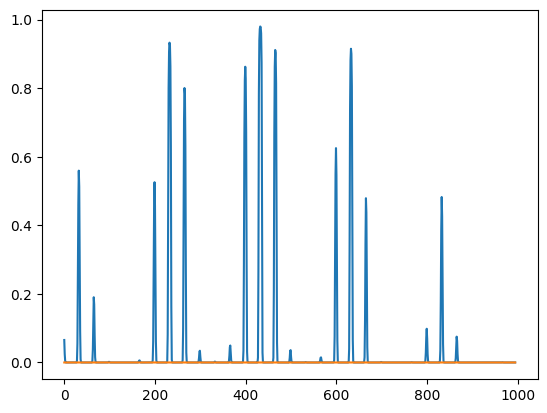

In [17]:
plt.plot(action_probs.squeeze(1).detach().numpy())

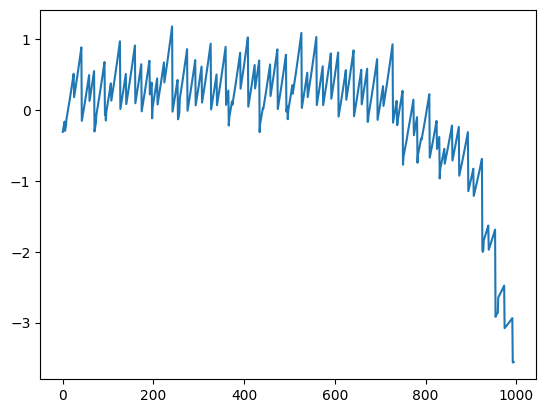

In [18]:
plt.plot(discounted_rewards)

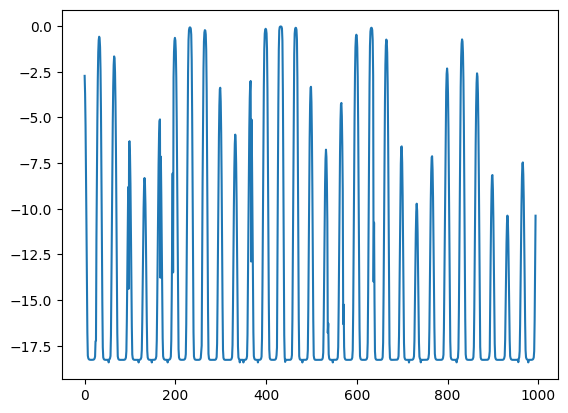

In [19]:
plt.plot(log_probs.detach().numpy())

In [20]:
policy_net.fc1.weight

Parameter containing:
tensor([[-11.5707, -11.3363, -10.1112, -10.2289],
        [-11.6802, -10.9066, -10.0193,  -9.1144],
        [ 10.3466,   9.6608,   9.4522,   8.6369],
        [-10.0502, -10.0645,  -9.2923,  -7.5777],
        [-10.9870, -10.5773, -10.5407, -10.0212],
        [-11.0525, -11.1429, -10.1951,  -9.8930],
        [ 11.3972,  10.8174,  10.3844,   9.7284],
        [ 11.8678,  11.4956,  11.1245,  11.0695]], requires_grad=True)

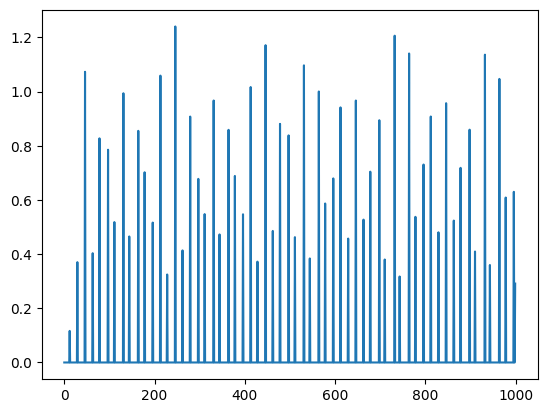

In [21]:
env.evaluate()
plt.plot(env.rewards)

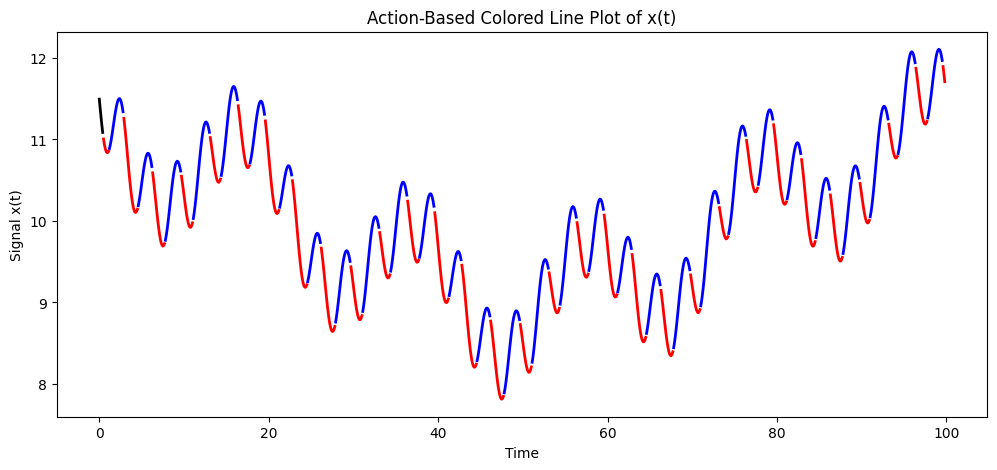

In [22]:
policy_net.epsilon=0.0
env.executePolicy(policy_net)
env.drawResult()